In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# An Ensemble based approach for image classification

This notebook encapsulates the research I've done with the Fashion MNIST dataset. I have experimented with multiple algorithms to create a diverse set of models as base learners for the ensemble models.

The list of models used based on type:

1. Tree: \
Decision Trees
2. Linear \
Logistic Regression


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import collections
from PIL import Image
from IPython.display import display
# import parfit.parfit as pf
import time
import numpy as np
from scipy import stats
# from boruta import BorutaPy
# from dask_ml import model_selection


from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
                              VotingClassifier, ExtraTreesClassifier, \
                              AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV, ParameterGrid, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
                            recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

dir = '/content/drive/My Drive/Fashion MNIST/'
pd.options.display.float_format = '{:,.2f}'.format

## Data Preprocessing

In [52]:
#Extracting the training and test data
train_df = pd.read_csv(dir + 'fashion-mnist_train.csv')
test_df = pd.read_csv(dir + 'fashion-mnist_test.csv')

print(train_df.values.shape)
print(test_df.values.shape)

(60000, 785)
(10000, 785)


In [0]:
#Retrieving the save features that were picked by Bouruta as the most important features
features = pd.read_csv('/content/drive/My Drive/Fashion MNIST/boruta_features_new.csv')
new_cols = list(features["Boruta Features"])

In [0]:
#Filtering both train and test for futher evaluation
new_train_df = train_df[["label"] + new_cols]
new_test_df = test_df[["label"] + new_cols]

In [0]:
x_train = new_train_df.iloc[:,1:].values
y_train = new_train_df.iloc[:,0].values
x_test = new_test_df.iloc[:,1:].values
y_test = new_test_df.iloc[:,0].values
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
           "Shirt", "Sneaker", "Bag", "Ankle boot"]

#Z-Score normalization:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [0]:
#All models are optimized based on previous experiments
model_list = {
"RF_" : RandomForestClassifier(criterion="entropy", n_estimators=100, 
                            random_state=42),
"KNN_" : KNeighborsClassifier(n_neighbors=1, n_jobs=-1),
"LR_" : LogisticRegression(solver="sag", multi_class='auto',
                         max_iter=500, random_state=42),
"NB_" : GaussianNB(),
"SVM_" : BaggingClassifier(SVC(kernel='rbf', C=100, max_iter=2000),
                                n_estimators=3, max_samples=20000, 
                                bootstrap=False,random_state=42, 
                                n_jobs=-1, verbose=10)

}

model_key = {
    "Random Forest" : 'RF_',
    "KNN" : 'KNN_',
    "Logistic Reg" : "LR_",
    "Naive Bayes" : "NB_",
    "SVM RBF" : "SVM_"
}

#Model Evaluation functions

In [0]:
#Function for cross validation
#It returns, accuracies per fold for t-test later
#It also returns average accuracy, predictions and probabilty of predictions

def train_evaluation(model_name, prob_df, folds=10):
  kfold = KFold(folds)
  accuracies = []
  predictions = []
  predictions_proba = []

  i=1
  for train_index, test_index in kfold.split(x_train_scaled):
    X_train_cv, X_test_cv = x_train_scaled[train_index], x_train_scaled[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    model = model_list[model_name]

    model.fit(X_train_cv, y_train_cv)
    y_pred_cv = model.predict(X_test_cv)

    accuracies.append(accuracy_score(y_test_cv, y_pred_cv))
    predictions += list(y_pred_cv)

    #SVM predict_proba doesn't work as expected. Mentioned in sklearn docs.
    if model_name != "SVM":
      predictions_proba = model.predict_proba(X_test_cv)
      
      if len(prob_df) != 0:
        temp_prob_df = pd.DataFrame(columns=prob_df.columns.values)
        
        for col in np.arange(0, 10):
          temp_prob_df[model_name + str(col)] = predictions_proba[:,col]   

        prob_df = pd.concat([prob_df, temp_prob_df], axis=0)

      else:      
        for col in np.arange(0, 10):
          prob_df[model_name + str(col)] = predictions_proba[:,col]

    print("Fold {} done".format(i))
    i += 1
    
  return accuracies, (sum(accuracies)/folds), predictions, prob_df


In [0]:
#Function to display the confusion matrix 
def display_confusion_matrix(y_pred, model_name):
  
  cm = confusion_matrix(y_test, y_pred)

  df_cm = pd.DataFrame(cm, index = classes,
                          columns = classes)

  plt.subplots(figsize=(8, 5))
  ax = sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"fontsize":11},
                  cmap=sn.color_palette("GnBu_d"))
  ax.set_ylim(10.0, 0.0)
  ax.set_yticklabels(labels=classes, fontsize=13)
  ax.set_xticklabels(labels=classes, fontsize=13, rotation=25)
  ax.set_title(model_name)

  plt.show()

#Function to calculate test accuracy, precision and recall
def scores(y_pred, model_name):
  accuracy = accuracy_score(y_test, y_pred)
  #Since there is no class imbalance we can use macro instead of micro
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')

  return [model_name, accuracy * 100, precision * 100, recall * 100]

#Training multiple base learners
##List of learners in order:
1. Random Forest
2. KNearestNeighbout
3. Logistic Regression
4. Naive Bayes
5. SVM RBF as a Bagging classifier

In [0]:
#Cross validation on training data to see model's performance 
rf_pred_df = pd.DataFrame(columns=["RF_" + str(x) for x in np.arange(0, 10)])
accuracies, average_accuracy, rf_predictions, rf_pred_df = train_evaluation("RF_", rf_pred_df)

print("Average training accuracy {} ".format(average_accuracy * 100))

Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
Average training accuracy 88.32333333333334 


In [0]:
#Fitting the Random Forest classifier on the entire training data and saving the model   
rf = RandomForestClassifier(criterion="entropy", n_estimators=100, random_state=42)
start = time.time()
rf.fit(x_train_scaled,y_train)
end = time.time() - start
print("Training time : {} s".format(end))

Training time : 137.6559338569641 s


In [0]:
#KNN classifier 
knn_pred_df = pd.DataFrame(columns=["KNN_" + str(x) for x in np.arange(0, 10)])
knn_acc , avg_acc, knn_predictions, knn_pred_df = train_evaluation("KNN_", knn_pred_df)

print("Average training accuracy {} ".format(avg_acc * 100))

Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
Average training accuracy 84.89166666666665 


In [0]:
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
start = time.time()
knn.fit(x_train_scaled,y_train)
end = time.time() - start
print("Training time : {} s".format(end))

Training time : 8.398613929748535 s


In [0]:
#Logistic regression for predictions and probabilties
lr_pred_df = pd.DataFrame(columns=["LR_" + str(x) for x in np.arange(0, 10)])
lr_acc, avg_acc, lr_predictions, lr_pred_df = train_evaluation("LR_", lr_pred_df)

print("Average training accuracy {} ".format(avg_acc * 100))

Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
Average training accuracy 85.12 


In [0]:
lr = LogisticRegression(solver="sag", multi_class='auto',
                         max_iter=500, random_state=42)
start = time.time()
lr.fit(x_train_scaled,y_train)
end = time.time() - start
print("Training time : {} s".format(end))

Training time : 565.0624206066132 s


In [0]:
#Naive Bayes accurac, predictions and predictions probabilties
nb_pred_df = pd.DataFrame(columns=["NB_" + str(x) for x in np.arange(0, 10)])
nb_acc, avg_acc, nb_predictions, nb_pred_df = train_evaluation("NB_", nb_pred_df)

print("Average training accuracy {} ".format(avg_acc * 100))

Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
Average training accuracy 66.14666666666666 


In [0]:
nb = GaussianNB()
start = time.time()
nb.fit(x_train_scaled,y_train)
end = time.time() - start
print("Training time : {} s".format(end))

Training time : 0.9555280208587646 s


In [0]:
#SVM RBF used as a bagging classifier with random sampling no replacement
svm_pred_df = pd.DataFrame(columns=["SVM_" + str(x) for x in np.arange(0, 10)])
svm_acc, avg_acc, svm_predictions, svm_pred_df = train_evaluation("SVM_", svm_pred_df)

print("Average training accuracy {} ".format(avg_acc))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished


Fold 1 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished


Fold 2 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished


Fold 3 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished


Fold 4 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished


Fold 5 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished


Fold 6 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished


Fold 7 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished


Fold 8 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished


Fold 9 done


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fold 10 done
Average training accuracy 0.8788666666666666 


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished


In [0]:
bagging_svm = BaggingClassifier(SVC(kernel='rbf', C=100, max_iter=2000),
                                n_estimators=3, max_samples=20000, bootstrap=False,
                                random_state=42, n_jobs=-1, verbose=10)
start = time.time()
bagging_svm.fit(x_train_scaled,y_train)
end = time.time() - start
print("Training time : {} s".format(end))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Training time : 189.27517580986023 s


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.2min finished


In [0]:
#Merging fold accuracies for t-test later
path='/content/drive/My Drive/Fashion MNIST/'

fold_acc_df = pd.DataFrame(columns=model_list.keys())
fold_acc_df['RF_'] = accuracies
fold_acc_df['KNN_'] = knn_acc
fold_acc_df['LR_'] = lr_acc
fold_acc_df['NB_'] = nb_acc
fold_acc_df['SVM_'] = svm_acc

fold_acc_df.to_csv(path+"fold_acc_boruta_2.csv", index=False)

In [0]:
#Merging fold predictions
path='/content/drive/My Drive/Fashion MNIST/'

fold_pred_df = pd.DataFrame(columns=model_list.keys())
fold_pred_df['RF_'] = rf_predictions
fold_pred_df['KNN_'] = knn_predictions
fold_pred_df['LR_'] = lr_predictions
fold_pred_df['NB_'] = nb_predictions
fold_pred_df['SVM_'] = svm_predictions

fold_pred_df.to_csv(path+"fold_pred_boruta_2.csv", index=False)

In [0]:
#Merging fold predictions probabilities
path='/content/drive/My Drive/Fashion MNIST/'
all_pred_proba_df = pd.concat([rf_pred_df, knn_pred_df,
                               lr_pred_df, nb_pred_df], axis=1)
all_pred_proba_df.to_csv(path + "fold_boruta_pred_prob_1.csv", index=False)

In [0]:

path='/content/drive/My Drive/Fashion MNIST/'
fold_acc_df.to_csv(path + 'fold_acc_boruta_2.csv', index=False)

In [0]:
#Rule based learner
dc = DummyClassifier(random_state=42)

start = time.time()
dc.fit(x_train_scaled,y_train)
end = time.time() - start
print("Training time : {} s".format(end))

Training time : 0.006719350814819336 s


In [0]:
#Get all the optimized models for predictions
rf = load('/content/drive/My Drive/Fashion MNIST/random_forest_1.joblib')
knn = load('/content/drive/My Drive/Fashion MNIST/knn_1.joblib')
lr = load('/content/drive/My Drive/Fashion MNIST/logistic_regression_1.joblib')
nb = load('/content/drive/My Drive/Fashion MNIST/naive_bayes_1.joblib')
svm = load('/content/drive/My Drive/Fashion MNIST/bagging_svm_rbf_2.joblib')

In [0]:
#Get all prediction probabilties from the 4 prob models
rf_test_pred_df = pd.DataFrame(data = rf.predict_proba(x_test_scaled),
                               columns=["RF_" + str(x) for x in np.arange(0, 10)])

knn_test_pred_df = pd.DataFrame(data = knn.predict_proba(x_test_scaled),
                               columns=["KNN_" + str(x) for x in np.arange(0, 10)])

lr_test_pred_df = pd.DataFrame(data = lr.predict_proba(x_test_scaled),
                               columns=["LR_" + str(x) for x in np.arange(0, 10)])

nb_test_pred_df = pd.DataFrame(data = nb.predict_proba(x_test_scaled),
                               columns=["NB_" + str(x) for x in np.arange(0, 10)])

In [0]:
#Save all the predicted probabilties
all_pred_proba_df = pd.concat([rf_test_pred_df, knn_test_pred_df,
                               lr_test_pred_df, nb_test_pred_df], axis=1)
all_pred_proba_df.to_csv("/content/drive/My Drive/Fashion MNIST/val_pred_prob_boruta_1.csv", index=False)

In [57]:
#Get all the saved csv files
train_pred_df = pd.read_csv('/content/drive/My Drive/Fashion MNIST/fold_pred_boruta_2.csv')
train_pred_prob_df = pd.read_csv('/content/drive/My Drive/Fashion MNIST/fold_boruta_pred_prob_2.csv')
test_pred_df = pd.read_csv('/content/drive/My Drive/Fashion MNIST/val_pred_boruta_3.csv')
test_pred_prob_df = pd.read_csv('/content/drive/My Drive/Fashion MNIST/val_pred_prob_boruta_1.csv')

test_pred_df.head()

,KNN,Random Forest,Logistic Reg,Naive Bayes,SVM RBF
0,0,0,0,0,0
1,1,1,1,1,1
2,2,2,2,6,6
3,2,2,0,2,0
4,3,3,4,3,4


Results for KNN : 


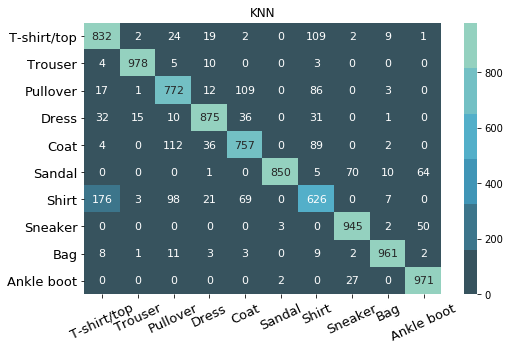


Results for Random Forest : 


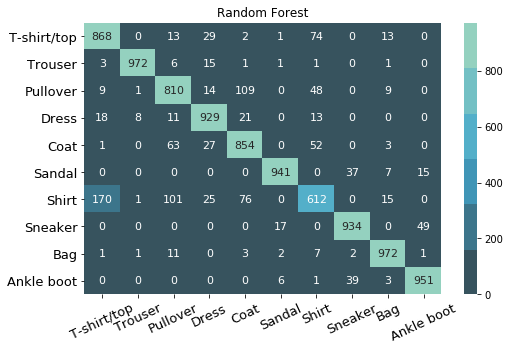


Results for Logistic Reg : 


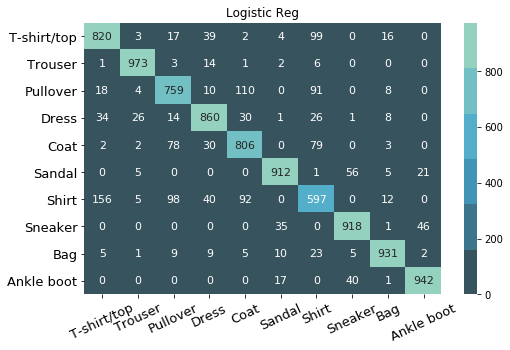


Results for Naive Bayes : 


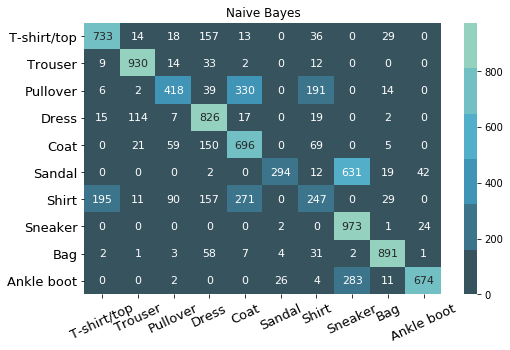


Results for SVM RBF : 


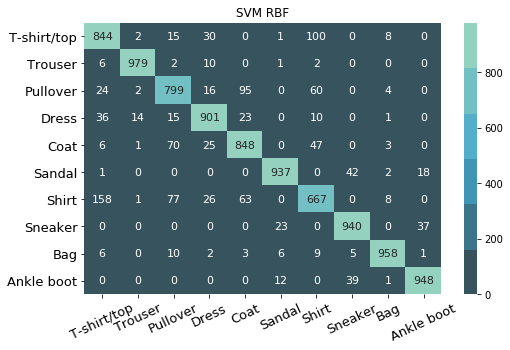

,Model,Accuracy,Precision,Recall
0,KNN,85.67,85.82,85.67
1,Random Forest,88.43,88.32,88.43
2,Logistic Reg,85.18,85.05,85.18
3,Naive Bayes,66.82,70.15,66.82
4,SVM RBF,88.21,88.18,88.21


In [0]:
#Results for all the models (base learners) that I've tried

scores_df = pd.DataFrame(columns=["Model","Accuracy", "Precision", "Recall"])

for model in test_pred_df.columns.values:
  print("Results for %s : " % (model))
  display_confusion_matrix(test_pred_df[model], model)
  scores_df.loc[len(scores_df)] = scores(test_pred_df[model], model)
  print()

scores_df.to_csv('/content/drive/My Drive/Fashion MNIST/Results/base_models.csv', index=False)
scores_df

#Tesing Ensemble models with the pre hyper parameter tuned base learners
##List of Ensemble methods researched in order of appearance:
1. Max Voting on predictions
2. Average on predictiosn
3. Weighted Average on predictions
4. Stacking \
  4.1 Stacking with class probabilities \
  4.2 Stacking with class predictions

In [0]:
#Create a dictionary of all model combinations paired based on accuracy
model_dict = {
"All base models" : ["SVM RBF", "Random Forest", "Logistic Reg", "KNN", "Naive Bayes" ],
"Top 4 models" : ["SVM RBF", "Random Forest", "Logistic Reg", "KNN"],
"Top 3 models" : ["SVM RBF", "Random Forest", "KNN"],
"Top 2 models" : ["SVM RBF", "Random Forest"]
}

model_prob_dict = {
"All base models" : ["Random Forest", "Logistic Reg", "KNN", "Naive Bayes"],
"Top 3 models" : ["Random Forest", "Logistic Reg", "KNN"],
"Top 2 models" : ["Random Forest", "KNN"]
}

In [0]:
test_pred_df.head()

,KNN,Random Forest,Logistic Reg,Naive Bayes,SVM RBF
0,0,0,0,0,0
1,1,1,1,1,1
2,2,2,2,6,6
3,2,2,0,2,0
4,3,3,4,3,4


In [0]:
#Voting ensembles

voting_ensemble_pred = pd.DataFrame(columns=model_dict.keys())

for model_batch in model_dict.keys():
  X_test_pred = test_pred_df[model_dict[model_batch]].values
  y_pred = stats.mode(X_test_pred, axis=1)[0] #Implementing hard voting. Literal marjority rule
  y_pred = y_pred.reshape(10000)
  voting_ensemble_pred[model_batch] = y_pred

voting_ensemble_pred.head()

,All base models,Top 4 models,Top 3 models,Top 2 models
0,0,0,0,0
1,1,1,1,1
2,2,2,2,2
3,2,0,2,0
4,3,3,3,3


Results for All base models : 


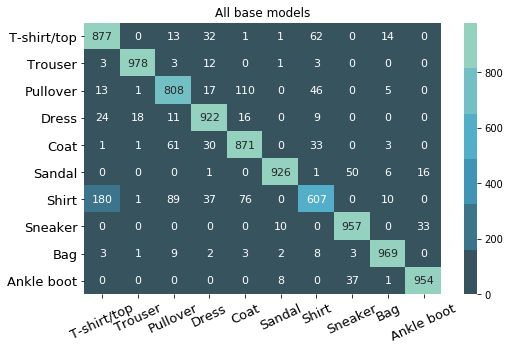


Results for Top 4 models : 


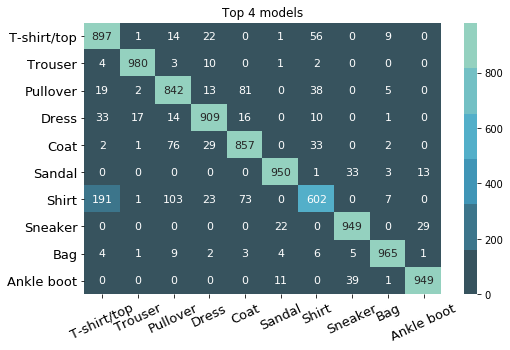


Results for Top 3 models : 


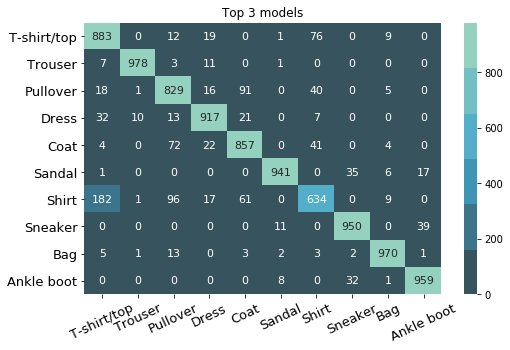


Results for Top 2 models : 


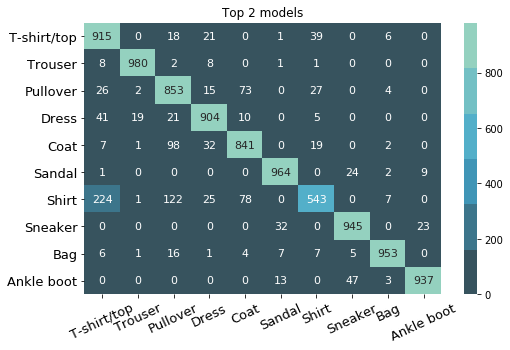

,Model,Accuracy,Precision,Recall
0,All base models,88.69,88.64,88.69
1,Top 4 models,89.00,89.03,89.00
2,Top 3 models,89.18,89.20,89.18
3,Top 2 models,88.35,88.73,88.35


In [0]:
scores_df = pd.DataFrame(columns=["Model","Accuracy", "Precision", "Recall"])

for model in voting_ensemble_pred.columns.values:
  print("Results for %s : " % (model))
  display_confusion_matrix(voting_ensemble_pred[model], model)
  scores_df.loc[len(scores_df)] = scores(voting_ensemble_pred[model], model)
  print()

scores_df.to_csv('/content/drive/My Drive/Fashion MNIST/Results/voting_ensemble.csv', index=False)
scores_df

In [0]:
#For averaging the predictions


avg_ensemble_pred = pd.DataFrame(columns=model_dict.keys())

for model_list in model_dict.keys():
  X_test_pred = test_pred_df[model_dict[model_list]].values
  averages = np.round(np.average(X_test_pred, axis=1)).astype(int)
  avg_ensemble_pred[model_list] = averages

avg_ensemble_pred.head()

,All base models,Top 4 models,Top 3 models,Top 2 models
0,0,0,0,0
1,1,1,1,1
2,4,3,3,4
3,1,1,1,1
4,3,4,3,4


Results for All base models : 


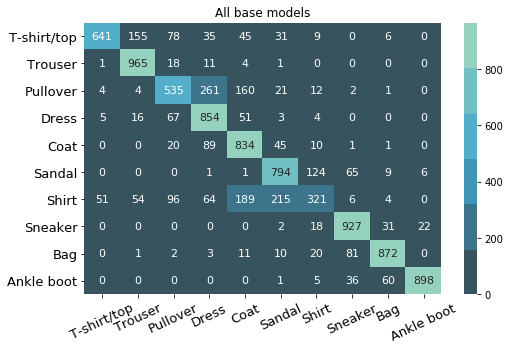


Results for Top 4 models : 


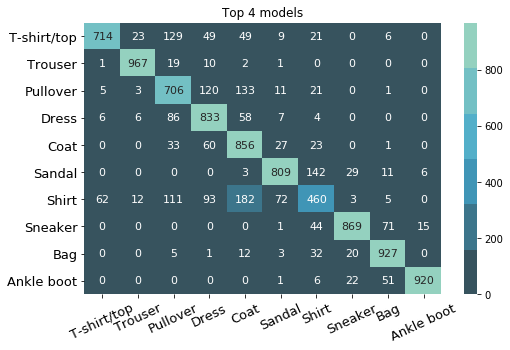


Results for Top 3 models : 


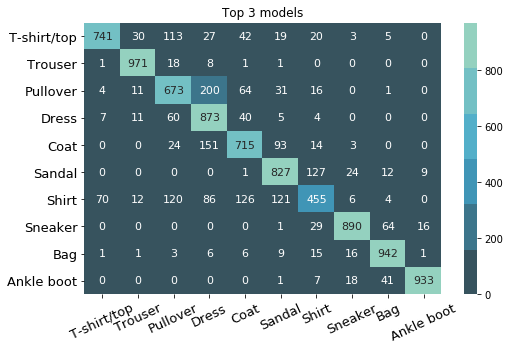


Results for Top 2 models : 


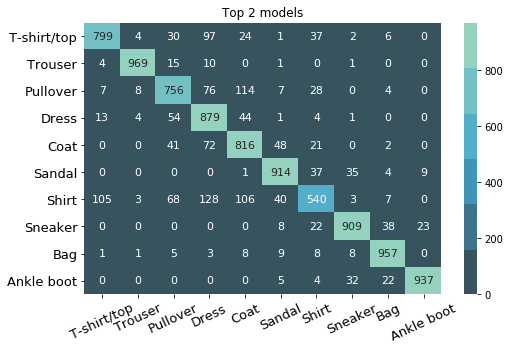

,Model,Accuracy,Precision,Recall
0,All base models,76.41,76.74,76.41
1,Top 4 models,80.61,81.20,80.61
2,Top 3 models,80.20,80.57,80.20
3,Top 2 models,84.76,85.07,84.76


In [0]:
scores_df = pd.DataFrame(columns=["Model","Accuracy", "Precision", "Recall"])

for model in avg_ensemble_pred.columns.values:
  print("Results for %s : " % (model))
  display_confusion_matrix(avg_ensemble_pred[model], model)
  scores_df.loc[len(scores_df)] = scores(avg_ensemble_pred[model], model)
  print()

scores_df.to_csv('/content/drive/My Drive/Fashion MNIST/Results/average_ensemble.csv', index=False)
scores_df

In [0]:
#For weighted average model experiment

model_weights = {
"All base models" : [0.30, 0.35, 0.15, 0.15, 0.05 ],
"Top 4 models" : [0.32, 0.38, 0.15, 0.15],
"Top 3 models" : [0.37, 0.43, 0.2],
"Top 2 models" : [0.48, 0.52],
}

weight_avg_ensemble_pred = pd.DataFrame(columns=model_dict.keys())

for model_list in model_dict.keys():
  X_test_pred = test_pred_df[model_dict[model_list]].values
  averages = np.round(
                np.average(X_test_pred, axis=1, 
                           weights=model_weights[model_list])).astype(int)
  weight_avg_ensemble_pred[model_list] = averages

weight_avg_ensemble_pred.head()

,All base models,Top 4 models,Top 3 models,Top 2 models
0,0,0,0,0
1,1,1,1,1
2,3,3,3,4
3,1,1,1,1
4,3,3,3,3


Results for All base models : 


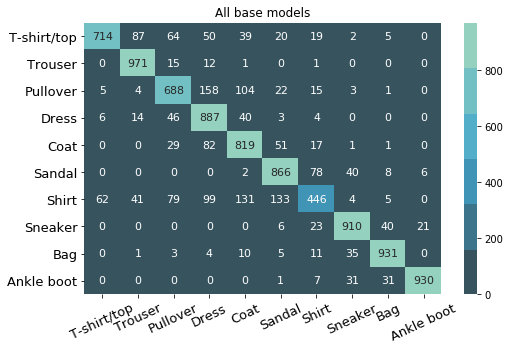


Results for Top 4 models : 


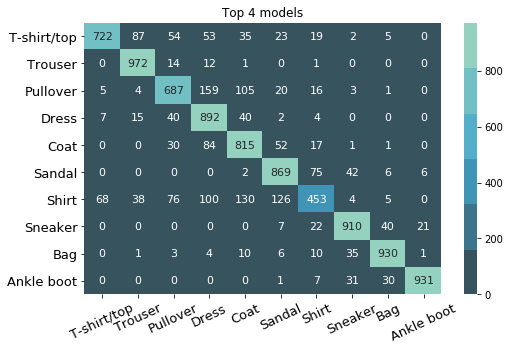


Results for Top 3 models : 


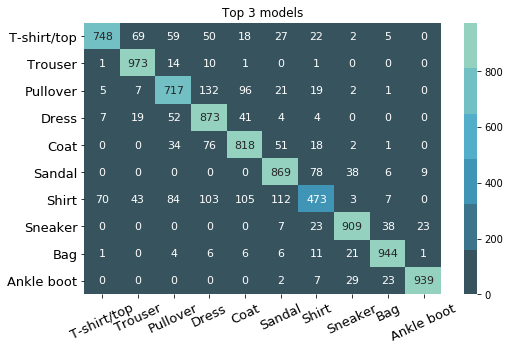


Results for Top 2 models : 


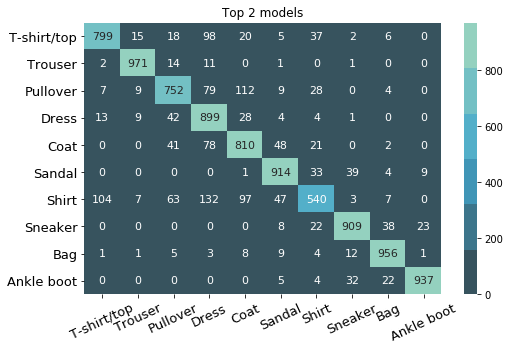

,Model,Accuracy,Precision,Recall
0,All base models,81.62,81.92,81.62
1,Top 4 models,81.81,82.12,81.81
2,Top 3 models,82.63,82.73,82.63
3,Top 2 models,84.87,85.17,84.87


In [0]:
#Display results of weighted average models scores
scores_df = pd.DataFrame(columns=["Model","Accuracy", "Precision", "Recall"])

for model in weight_avg_ensemble_pred.columns.values:
  print("Results for %s : " % (model))
  display_confusion_matrix(weight_avg_ensemble_pred[model], model)
  scores_df.loc[len(scores_df)] = scores(weight_avg_ensemble_pred[model], model)
  print()

scores_df.to_csv('/content/drive/My Drive/Fashion MNIST/Results/weighted_average_ensemble.csv', index=False)
scores_df

Results for All base models : 


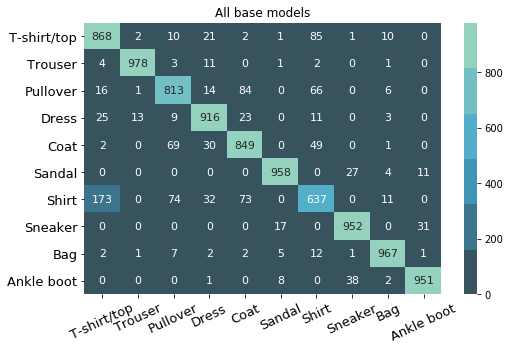


Results for Top 4 models : 


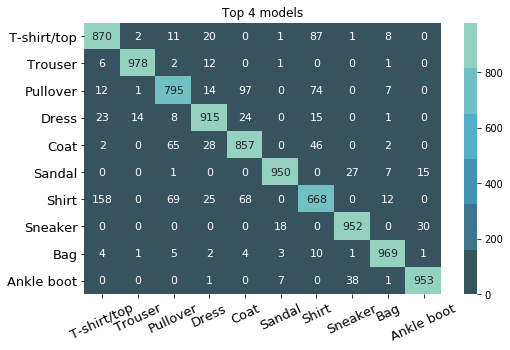


Results for Top 3 models : 


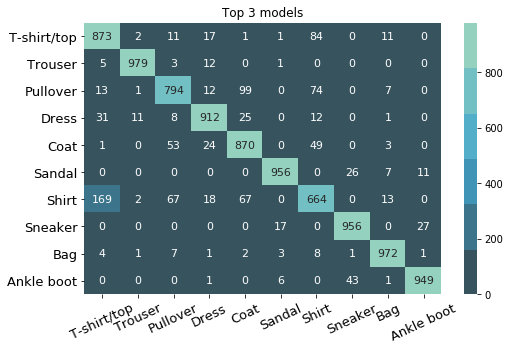


Results for Top 2 models : 


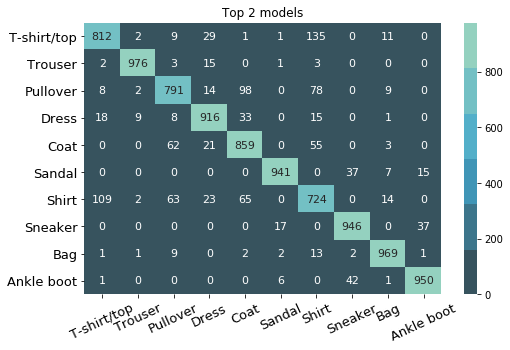

,Model,Accuracy,Precision,Recall
0,All base models,88.89,88.78,88.89
1,Top 4 models,89.07,89.00,89.07
2,Top 3 models,89.25,89.21,89.25
3,Top 2 models,88.84,88.89,88.84


In [0]:
#Stacking Ensemble experiment

#Stacking with predictions of previous models

clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

scores_df = pd.DataFrame(columns=["Model","Accuracy", "Precision", "Recall"])

for model in model_dict.keys():

  new_model_keys = []
  for curr_model in model_dict[model]:
    new_model_keys.append(model_key[curr_model])

  X_train_pred = train_pred_df[new_model_keys].values
  X_test_pred = test_pred_df[model_dict[model]].values

  clf.fit(X_train_pred, y_train)
  y_pred = clf.predict(X_test_pred)

  print("Results for %s : " % (model))
  display_confusion_matrix(y_pred, model)
  scores_df.loc[len(scores_df)] = scores(y_pred, model)
  print()

scores_df.to_csv('/content/drive/My Drive/Fashion MNIST/Results/stacking_predictions.csv', index=False)
scores_df

Results for Top 2 models : 


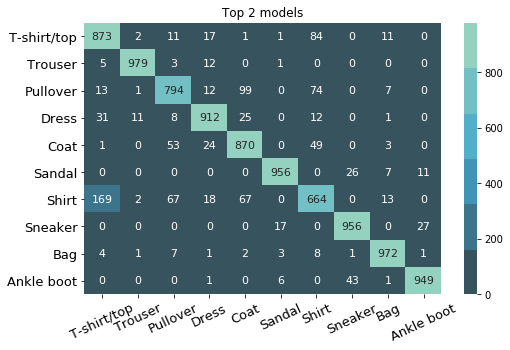

In [61]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

scores_df = pd.DataFrame(columns=["Model","Accuracy", "Precision", "Recall"])

new_model_keys = []
for curr_model in model_dict[model]:
  new_model_keys.append(model_key[curr_model])

X_train_pred = train_pred_df[["SVM_", "RF_", "KNN_"]].values
X_test_pred = test_pred_df[["SVM RBF", "Random Forest", "KNN"]].values

clf.fit(X_train_pred, y_train)
y_pred = clf.predict(X_test_pred)

print("Results for %s : " % (model))
display_confusion_matrix(y_pred, model)
scores_df.loc[len(scores_df)] = scores(y_pred, model)
print()

In [63]:
dump(clf, '/content/drive/My Drive/Fashion MNIST/decision_tree_1.joblib')

['/content/drive/My Drive/Fashion MNIST/decision_tree_1.joblib']

Results for All base models : 


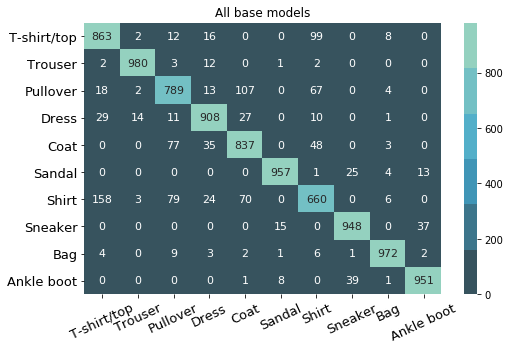


Results for Top 3 models : 


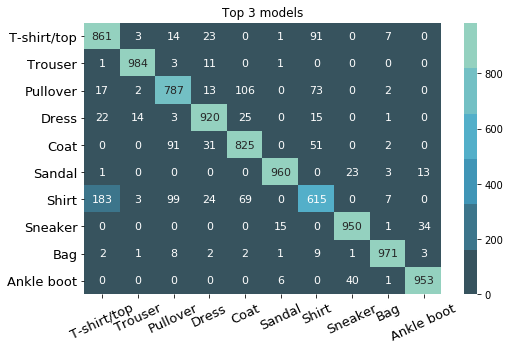


Results for Top 2 models : 


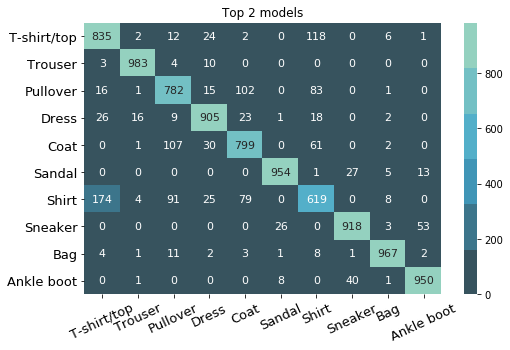

,Model,Accuracy,Precision,Recall
0,All base models,88.65,88.58,88.65
1,Top 3 models,88.26,88.13,88.26
2,Top 2 models,87.12,87.01,87.12


In [0]:
#Stacking with predictions of previous models

#DT works good but ExtraTrees works better but also more complex
# clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf = ExtraTreesClassifier(n_estimators=10, criterion='entropy', random_state=42)

scores_df = pd.DataFrame(columns=["Model","Accuracy", "Precision", "Recall"])

for model in model_prob_dict.keys():

  new_model_keys = []
  for curr_model in model_prob_dict[model]:
    temp_col_list = [model_key[curr_model] + str(x) for x in np.arange(0, 10)]
    new_model_keys += temp_col_list

  X_train_pred = train_pred_prob_df[new_model_keys].values
  X_test_pred = test_pred_prob_df[new_model_keys].values

  clf.fit(X_train_pred, y_train)
  y_pred = clf.predict(X_test_pred)

  print("Results for %s : " % (model))
  display_confusion_matrix(y_pred, model)
  scores_df.loc[len(scores_df)] = scores(y_pred, model)
  print()

scores_df.to_csv('/content/drive/My Drive/Fashion MNIST/Results/stacking prediction prob.csv', index=False)
scores_df

##Statistical Equivalence test for Base learners

In [0]:
fold_acc_df = pd.read_csv('/content/drive/My Drive/Fashion MNIST/fold_acc_boruta_2.csv')

In [0]:
base_learner_acc_df =  fold_acc_df.rename(columns={"RF_": "Random Forest", 
                                                   "SVM_" : "SVM RBF",
                                                   "KNN_" : "KNN",
                                                   "NB_" : "Naive Bayes",
                                                   "LR_" : "Logistic Regression"})

In [0]:
base_learner_acc_df

,Random Forest,KNN,Logistic Regress,Naive Bayes,SVM RBF
0,0.89,0.85,0.86,0.66,0.88
1,0.88,0.85,0.85,0.67,0.88
2,0.89,0.85,0.85,0.67,0.88
3,0.88,0.85,0.85,0.65,0.88
4,0.89,0.85,0.85,0.67,0.88
5,0.88,0.85,0.85,0.66,0.88
6,0.88,0.85,0.85,0.66,0.88
7,0.88,0.84,0.85,0.66,0.88
8,0.89,0.85,0.85,0.65,0.88
9,0.88,0.85,0.84,0.66,0.88


In [0]:

p_test_row = [] 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['RF_'], fold_acc_df['SVM_']).pvalue) 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['RF_'], fold_acc_df['KNN_']).pvalue) 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['RF_'], fold_acc_df['LR_']).pvalue) 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['RF_'], fold_acc_df['NB_']).pvalue) 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['SVM_'], fold_acc_df['KNN_']).pvalue)
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['SVM_'], fold_acc_df['LR_']).pvalue) 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['SVM_'], fold_acc_df['NB_']).pvalue) 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['KNN_'], fold_acc_df['LR_']).pvalue) 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['KNN_'], fold_acc_df['NB_']).pvalue) 
p_test_row.append("%.5f" % stats.ttest_rel(fold_acc_df['LR_'], fold_acc_df['NB_']).pvalue) 

p_test_row = [str(x) for x in p_test_row]
result_row = ["Significant" if (float(p_test_row[idx]) < 0.05) else "Not" for idx, i in enumerate(p_test_row)]

p_test_df = pd.DataFrame(columns=[ "RF v SVM",
								   "RF v KNN",
								   "RF v LR",
								   "RF v NB",
								   "SVM v KNN",
								   "SVM v LR",
                   "SVM v NB",
                   "KNN v LR",
                   "KNN v NB",
                   "LR v NB"],
						   data = [p_test_row, result_row])

p_test_df.to_csv('/content/drive/My Drive/Fashion MNIST/p_test_results.csv', index=False)
p_test_df

,RF v SVM,RF v KNN,RF v LR,RF v NB,SVM v KNN,SVM v LR,SVM v NB,KNN v LR,KNN v NB,LR v NB
0,0.00038,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10050,0.00000,0.00000
1,Significant,Significant,Significant,Significant,Significant,Significant,Significant,Not,Significant,Significant
